In [1]:
!pip install transformers

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2024-01-21 09:59:49--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‘AirlineTweets.csv’

AirlineTweets.csv   100%[===================>]   3.26M  4.61MB/s    in 0.7s    

2024-01-21 09:59:51 (4.61 MB/s) - ‘AirlineTweets.csv’ saved [3421431/3421431]



In [5]:
from transformers import pipeline
import numpy as np
import pandas as pd
import seaborn as sn

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix


In [6]:
classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [7]:
type(classifier)

transformers.pipelines.text_classification.TextClassificationPipeline

In [9]:
classifier('this is a not that great movie')

[{'label': 'NEGATIVE', 'score': 0.9997281432151794}]

In [11]:
device = torch.cuda.current_device()

In [13]:
# using the GPU now

classifier = pipeline("sentiment-analysis",device = device )

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [14]:
df_ = pd.read_csv('/content/AirlineTweets.csv')

In [16]:
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [27]:
df = df_[['text','airline_sentiment']].copy()

In [28]:
df.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


<Axes: >

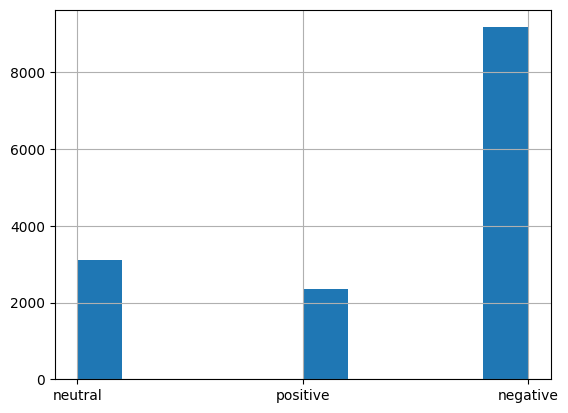

In [29]:
df['airline_sentiment'].hist()       ### so imbalanced dataset

In [30]:
df = df[df['airline_sentiment'] != 'neutral'].copy()        ### as the transformer model we are using doesn't trained on Neutral label data, only positive and negative

In [33]:
target_map = {'positive': 1, 'negative': 0}
df['target'] = df['airline_sentiment'].map(target_map)

In [34]:
df.head()

,text,airline_sentiment,target
1,@VirginAmerica plus you've added commercials t...,positive,1
3,@VirginAmerica it's really aggressive to blast...,negative,0
4,@VirginAmerica and it's a really big bad thing...,negative,0
5,@VirginAmerica seriously would pay $30 a fligh...,negative,0
6,"@VirginAmerica yes, nearly every time I fly VX...",positive,1


In [35]:
len(df)

11541

In [38]:
texts = df['text'].tolist()
predictions = classifier(texts)

In [39]:
probs =  [d['score'] if d['label'].startswith('P') else 1- d['score'] for d in predictions]

In [40]:
probs   #### probabilities that a text is positive.

[0.6070840954780579,
 0.0026550889015197754,
 0.0004176497459411621,
 0.014574944972991943,
 0.9553212523460388,
 0.9827088117599487,
 0.9994851350784302,
 0.9993509650230408,
 0.9940821528434753,
 0.9863133430480957,
 0.9996304512023926,
 0.001948714256286621,
 0.9964436888694763,
 0.0031333565711975098,
 0.9787647724151611,
 0.9995218515396118,
 0.004548370838165283,
 0.9995624423027039,
 0.9998748302459717,
 0.004880666732788086,
 0.00040477514266967773,
 0.0006322264671325684,
 0.015428304672241211,
 0.01828092336654663,
 0.0004482865333557129,
 0.0023748278617858887,
 0.9934480786323547,
 0.9976067543029785,
 0.8661719560623169,
 0.0003237724304199219,
 0.8415618538856506,
 0.0032317638397216797,
 0.9997846484184265,
 0.1761431097984314,
 0.9993895292282104,
 0.09156662225723267,
 0.004861712455749512,
 0.9997820258140564,
 0.0014235973358154297,
 0.004673957824707031,
 0.00464242696762085,
 0.019041001796722412,
 0.991169810295105,
 0.0125504732131958,
 0.00809931755065918,
 0.99

In [41]:
preds = [1 if d['label'].startswith('P') else 0 for d in predictions]

In [44]:
type(preds)

list

In [45]:
len(preds)

11541

In [48]:
preds = np.array(preds)
preds

array([1, 0, 0, ..., 1, 0, 0])

In [49]:
print('accuracy:' , np.mean(df['target']== preds))

accuracy: 0.8898708950697514


In [50]:
cm = confusion_matrix(df['target'], preds, normalize= 'true')

In [51]:
cm

array([[0.90117673, 0.09882327],
       [0.15404147, 0.84595853]])

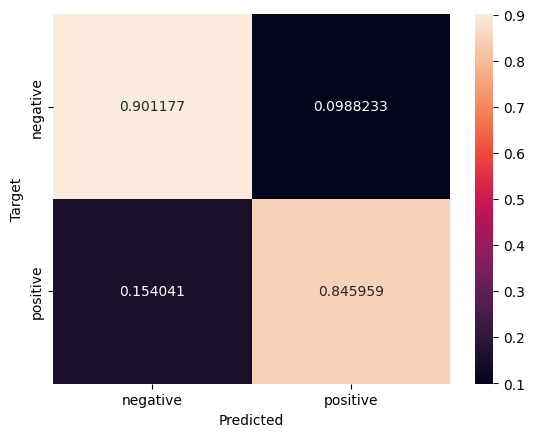

In [61]:
def plot_cm(cm):
  classes = ['negative', 'positive']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

plot_cm(cm)

In [ ]:
# A true positive is an outcome where the model correctly predicts the positive class. Similarly,
# a true negative is an outcome where the model correctly predicts the negative class.

In [52]:
f1_score(df['target'], preds)

0.7587777566900741

In [53]:
f1_score(1-df['target'], 1-preds)

0.928647616908999

In [58]:
roc_auc_score(df['target'], probs)

0.9485934690648773

In [60]:
roc_auc_score(1-df['target'], 1-np.array(probs))       ### roc_auc_score indictaes the discriminative power of the model, it accesses how well a model can distinguish between positive and negative instances.

0.9485934690648772

In [ ]:
# Receiver Operating Characteristic (ROC) Curve:

# The ROC curve is a graphical representation of a classifier's performance across various classification thresholds.
# It plots the True Positive Rate (Sensitivity or Recall) against the False Positive Rate (1 - Specificity) at different threshold settings.
# The curve visually illustrates the trade-off between sensitivity and specificity.

In [ ]:
# It's worth noting that while the ROC AUC score remains the same, other metrics like precision, recall, and F1 score may differ when you swap the positive and negative classes.
# The choice of which class to consider as the positive one is often arbitrary, and it depends on the specific context and the application.

In [ ]:
# git init
# git add README.md
# git commit -m "first commit"
# git branch -M main
# git remote add origin https://github.com/pavankumarchowdary35/NLP-projects.git
# git push -u origin main

In [62]:
!git init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [63]:
!git branch -M main